In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math 

import statsmodels.api as sm
from patsy import dmatrices

sns.set_theme()

In [2]:
def generate_data(rho, sigma2, n):
    
    # Covariance and mean
    cov = [[1, rho], [rho, 1]]
    mean = [0, 0]
    
    # Generate Betas and residual
    b0 = np.full((n,), 0)
    b1 = np.full((n,), 1)
    b2 =  np.full((n,), 1)
    e = np.random.normal(0, math.sqrt(sigma2), n)
    
    # Generate correlated X's and y
    X_1i, X_2i = np.random.multivariate_normal(mean, cov, n).T # Need to transpose so that it can unpack into 2 variables
    y = b0 + b1 * X_1i + b2 * X_2i + e
        
    # Throw everything into a dataframe
    df = pd.DataFrame({"e": e, "X1": X_1i, "X2": X_2i, "y": y})
    return df

In [3]:
def simulate(rho, sigma2, num_samples=1000, N=50):
    
    params_df = [] # A list to throw info into, which will become a dataframe
    
    # A loop 
    for n in range(num_samples):
        # Generate data, size(N) = 50
        df = generate_data(rho=rho, sigma2=sigma2, n=N)
        
        # Run the regression with the full model and the single variate
        y, X = dmatrices("y ~ X1 + X2", data=df, return_type="dataframe") # Forming endog and exog matrices
        # Run all 3 procedures described in the question
        procedure_one = sm.OLS(y, X).fit() # Procedure 1 regression
        procedure_two = sm.OLS(y, X[["Intercept", "X1"]]).fit() # Procedure 2 regression
        
        # load the estimates into a dictionary
        params = {"beta1_hat": procedure_one.params[1],
                  "beta2_hat": procedure_one.params[2],
                  "beta1_bar": procedure_two.params[1],
                  "beta2_tstat": procedure_one.tvalues[2],
                  "beta1hat_tstat": procedure_one.tvalues[1],
                  "beta1bar_tstat": procedure_two.tvalues[1],
                  "rsquared1": procedure_one.rsquared, 
                  "rsquared2": procedure_two.rsquared}
        params_df.append(params) # Append parameters
        
    # Throw it all into a dataframe
    out_df = pd.DataFrame(params_df).round(4)
    # This is our "procedure 3": 
    # make beta_tilde equal either beta1_hat or beta1_bar;
    out_df["beta1_tilde"] = np.where(np.abs(out_df["beta2_tstat"]) > 2, out_df["beta1_hat"], out_df["beta1_bar"])
    # use the following tstat for beta1;
    out_df["beta1tilde_tstat"] = np.where(np.abs(out_df["beta2_tstat"]) > 2, out_df["beta1hat_tstat"], out_df["beta1bar_tstat"])
    # use the following R-squared from either procedure 1 or 2
    out_df["rsquared3"] = np.where(np.abs(out_df["beta2_tstat"]) > 2, out_df["rsquared1"], out_df["rsquared2"])
    # Create a column to track whether beta tilde was taken from procedure 1 or 2
    out_df["beta_type"] = np.where(np.abs(out_df["beta2_tstat"]) > 2, "beta1_hat", "beta1_bar")
    
    return out_df

In [4]:
def run_scenarios(rhos=[0.2, 0.5, 0.8], sigma2s=[1, 5, 10]):
    output = pd.DataFrame()
    for p in rhos:
        for var in sigma2s:
            # Visual Progress
            print(f"===== Initiating Scenario (ρ={p}, sigma2={var}) =====")
            # Run our simulate function given the desired parameters
            params = simulate(p, var)
            params["scenario (ρ, sigma2)"] = f"{p}, {var}"
            output = pd.concat([output, params])
    return output

In [5]:
%%time
# Set Seed
np.random.seed(1234)
all_scenarios = run_scenarios()

===== Initiating Scenario (ρ=0.2, sigma2=1) =====
===== Initiating Scenario (ρ=0.2, sigma2=5) =====
===== Initiating Scenario (ρ=0.2, sigma2=10) =====
===== Initiating Scenario (ρ=0.5, sigma2=1) =====
===== Initiating Scenario (ρ=0.5, sigma2=5) =====
===== Initiating Scenario (ρ=0.5, sigma2=10) =====
===== Initiating Scenario (ρ=0.8, sigma2=1) =====
===== Initiating Scenario (ρ=0.8, sigma2=5) =====
===== Initiating Scenario (ρ=0.8, sigma2=10) =====
CPU times: user 31.8 s, sys: 133 ms, total: 31.9 s
Wall time: 32 s


In [6]:
all_scenarios

,beta1_hat,beta2_hat,beta1_bar,beta2_tstat,beta1hat_tstat,beta1bar_tstat,rsquared1,rsquared2,beta1_tilde,beta1tilde_tstat,rsquared3,beta_type,"scenario (ρ, sigma2)"
0,0.9991,0.9218,0.8955,7.4266,5.7182,3.5244,0.6345,0.2056,0.9991,5.7182,0.6345,beta1_hat,"0.2, 1"
1,1.1074,1.1032,1.2092,7.9106,7.0837,5.1367,0.7232,0.3547,1.1074,7.0837,0.7232,beta1_hat,"0.2, 1"
2,0.8211,1.0760,1.1080,8.4671,6.6245,5.9101,0.7708,0.4212,0.8211,6.6245,0.7708,beta1_hat,"0.2, 1"
3,1.1397,1.0756,1.4061,7.5156,7.3652,6.3571,0.7534,0.4571,1.1397,7.3652,0.7534,beta1_hat,"0.2, 1"
4,1.0752,1.0928,1.4708,8.9104,7.0297,6.1924,0.7933,0.4441,1.0752,7.0297,0.7933,beta1_hat,"0.2, 1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.8625,0.9600,1.4469,1.2232,1.3046,3.1499,0.1969,0.1713,1.4469,3.1499,0.1713,beta1_bar,"0.8, 10"
996,1.6180,-0.3316,1.3414,-0.4651,2.2210,3.2147,0.1809,0.1772,1.3414,3.2147,0.1772,beta1_bar,"0.8, 10"
997,2.6277,-1.3156,1.6831,-2.0014,4.4239,4.5278,0.3543,0.2993,2.6277,4.4239,0.3543,beta1_hat,"0.8, 10"
998,1.9485,0.9912,2.6836,1.2703,2.6787,6.0504,0.4515,0.4327,2.6836,6.0504,0.4327,beta1_bar,"0.8, 10"


### What can you say about the density of $β_1$ and $β_2$ across the three procedures as those parameters ρ and σ2 change.

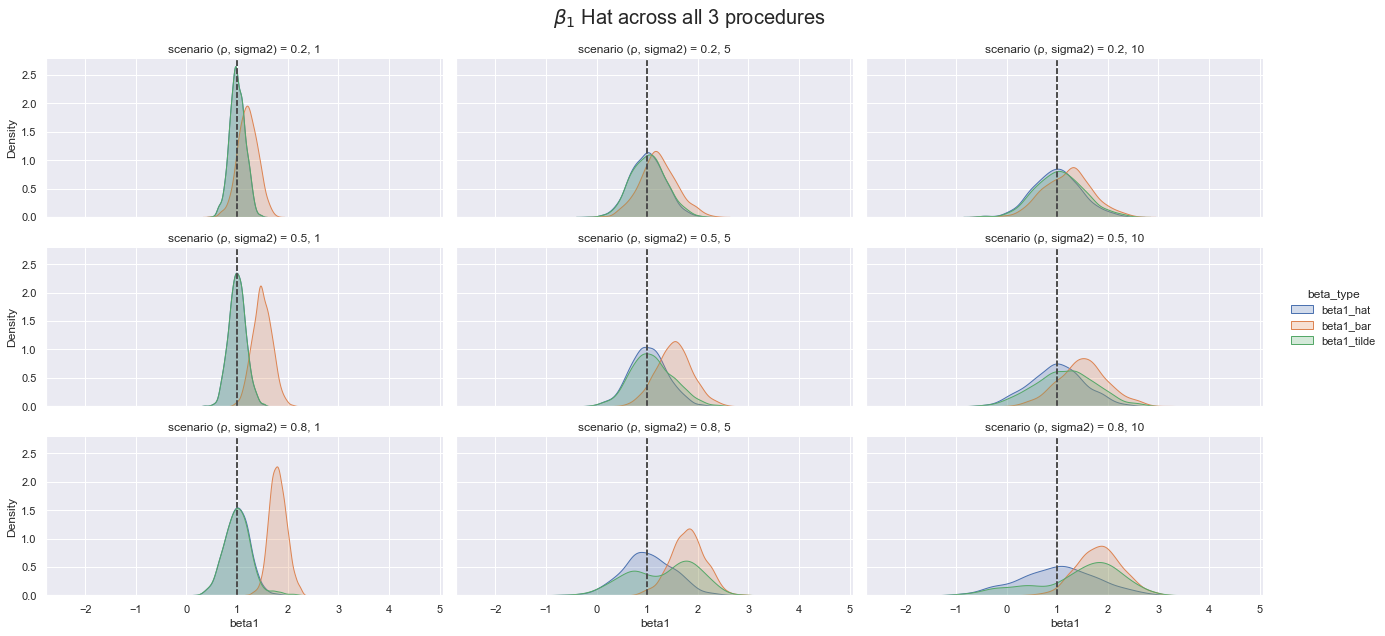

In [7]:
# Beta1 hat across all 3 procedures
subset = all_scenarios[["scenario (ρ, sigma2)", "beta1_hat", "beta1_bar", "beta1_tilde"]]
subset = pd.melt(subset, id_vars="scenario (ρ, sigma2)", var_name="beta_type", value_name="beta1")
g = sns.FacetGrid(subset, 
                  col="scenario (ρ, sigma2)", 
                  col_wrap=3, 
                  aspect=2, 
                  hue="beta_type")

g.map(sns.kdeplot, "beta1", **{"fill": True, "warn_singular": False})
g.add_legend()
g.refline(x=1, color="0.3")
# Setting Title
g.fig.subplots_adjust(top=0.9) # adjust the figure
g.fig.suptitle("$β_1$ Hat across all 3 procedures", fontsize=20)
g.savefig("beta1")

Starting in the top left region of **Figure 1**, we can see that beta1 is unbiased and efficient (small standard error and variance) in procedure 1 and 3 which is denoted by beta1_hat and beta1_tilde. Expectedly, we can see that beta1_bar has a slight upward bias from the procedure 1 and 3 estimates of beta 1 and the true value of beta 1 (which is 1), though remaining efficient (tight variance). Starting at the top row and moving to the right we can see that as the variance of our error term increases, the standard errors of both of our beta 1 distributions increase. Looking at the top row and moving down we can see that increasing the covariance between X_1 and X_2 (multicollinearity) makes our beta 1 from procedure 1 and 3 less efficient. We can also observe the procedure 2 beta 1 distribution becomes more biased towards 2, as beta1_bar is able to “soak up” more of the effects of beta 2.

Looking from the top left and diagonally down to the bottom right, we can see the effects in each procedure from increasing the variance in the error and the correlation between X_1 and X_2. In the middle graph when both the covariance and error variance increase, all 3 beta 1 distributions flatten and become wider (less efficient and larger standard errors), where procedure 2's beta 1 or beta1_bar becomes more biased than before. 
Then moving to the bottom right graph, as the covariance between X_1 and X_2 increases with the variance of our error term, we can see that the means of the beta 1s separate and form a bimodal shape. The left peak is when beta1_tilde equals beta1_hat and the right is when beta1_tilde equals beta1_bar and we can see that beta1_tilde moves towards a mean of 2. This is caused by the fact that as covariance and error increase, the significance of beta 2 will begin to decrease and eventually be dropped (procedure 3), explaining the movement of beta1_tilde away from a mean of 1 to a mean of 2, as it tries to capture the effects of both X_1 and X_2 (multicollinearity).

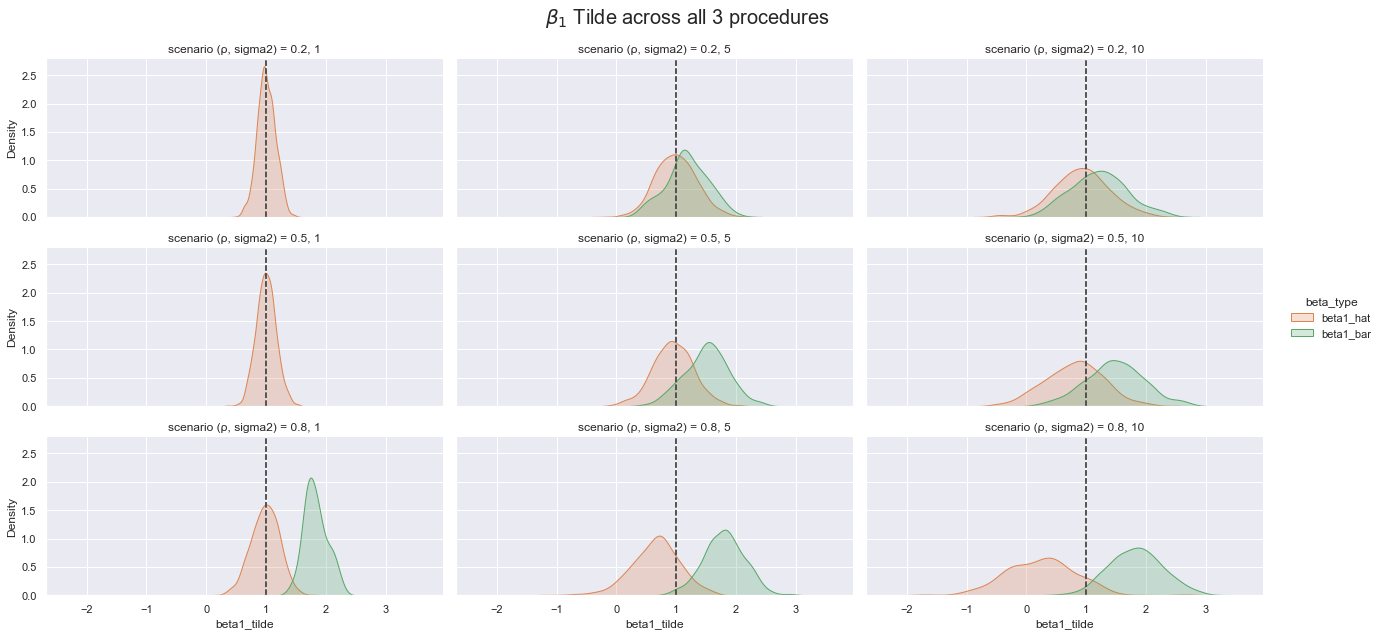

In [8]:
# Beta1 tilde across procedures 1 and 2
g = sns.FacetGrid(all_scenarios, 
                  col="scenario (ρ, sigma2)", 
                  col_wrap=3, 
                  aspect=2, 
                  hue="beta_type", 
                  palette=["C1", "C2"])

g.map(sns.kdeplot, "beta1_tilde", **{"fill": True, "warn_singular": False})
g.add_legend()
g.refline(x=1, color="0.3")
# Setting Title
g.fig.subplots_adjust(top=0.9) # adjust the figure
g.fig.suptitle("$β_1$ Tilde across all 3 procedures", fontsize=20)
g.savefig("beta1_tilde")

In **Figure 2**, we can see that as variance in the error term increases (moving from left to right), the standard errors (and variance) of our beta 1 tilde distributions widen, decreasing the significance of our beta distribution. We can also observe that the beta 1 tilde distributions in procedure 2 (or beta 1 bar) become more positively biased (towards a mean of 2) as the covariance between X_1 and X_2 increase, as beta 1 tilde tries to represent more of the explanatory power of both X_1 and X_2 - when X_2 is dropped. And we can see that as covariance between X_1 and X_2 are high and when the variance of the error term is high, beta1_tilde for beta1_hat begins shifting towards 0. This is essentially, putting more weight on beta2_hat, giving it all the explanatory power. 

<!-- ### PROCEDURE 2 -->

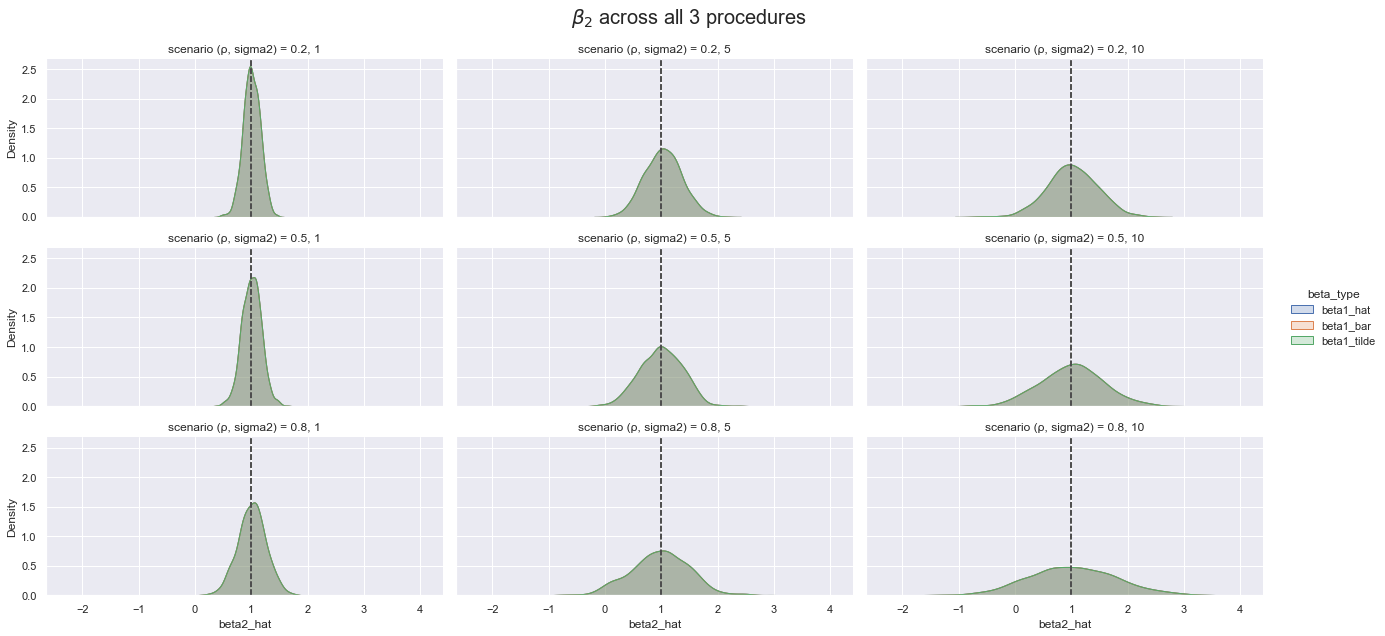

In [9]:
# Comparing beta2 hat across scenarios
subset2 = all_scenarios[["scenario (ρ, sigma2)", "beta1_hat", "beta1_bar", "beta1_tilde", "beta2_hat"]]
subset2 = pd.melt(subset2, id_vars=["scenario (ρ, sigma2)", "beta2_hat"], var_name="beta_type")

g = sns.FacetGrid(subset2, 
                  col="scenario (ρ, sigma2)", 
                  col_wrap=3, 
                  aspect=2, 
                  hue="beta_type")

g.map(sns.kdeplot, "beta2_hat", **{"fill": True, "warn_singular":False})
g.add_legend()
g.refline(x=1, color="0.3")
g.savefig("beta2")
g.fig.subplots_adjust(top=0.9) # adjust the figure
g.fig.suptitle("$β_2$ across all 3 procedures", fontsize=20)
g.savefig("beta2")

In Figure 3, we can see that beta2_hat doesn't not change across the 3 procedures and 9 scenarios.

### In procedure 3, is the density of β2 similar if included to if it is dropped?

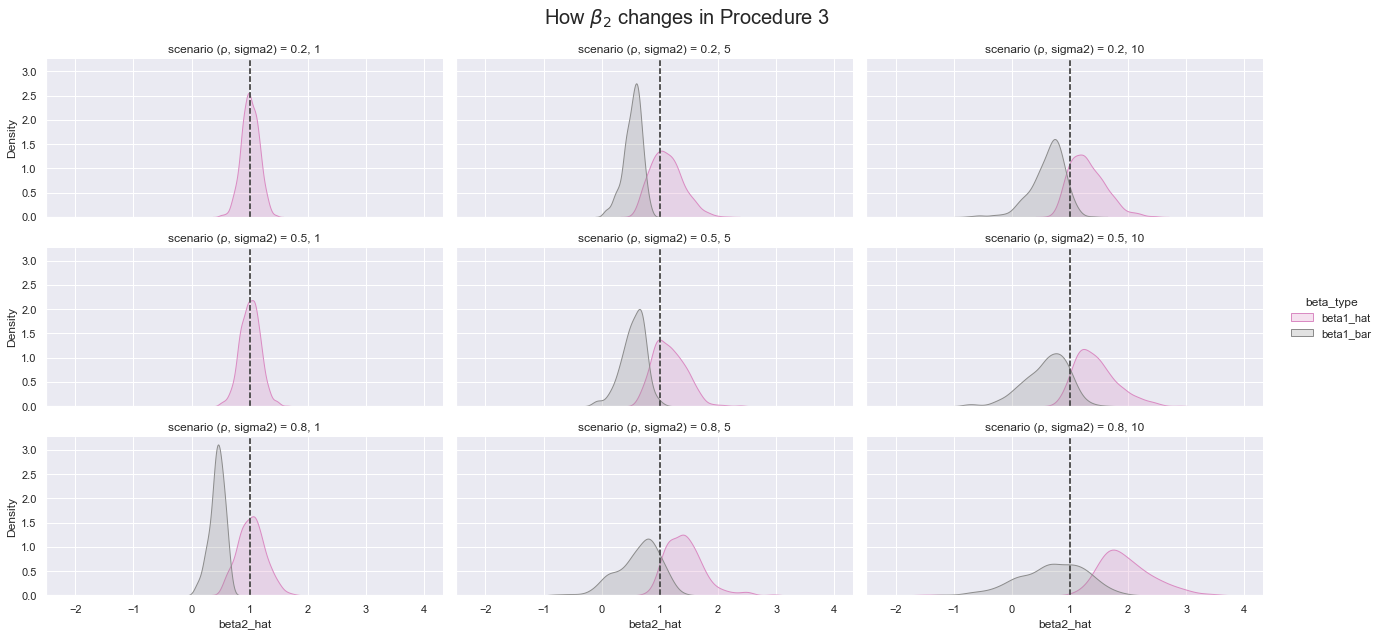

In [10]:
g = sns.FacetGrid(all_scenarios, 
                  col="scenario (ρ, sigma2)",
                  col_wrap=3, 
                  aspect=2, 
                  palette=["C6", "C7"], 
                  hue="beta_type")

g.map(sns.kdeplot, "beta2_hat", **{"fill": True, "warn_singular":False})
g.add_legend()
g.refline(x=1, color="0.3")
# Setting Title
g.fig.subplots_adjust(top=0.9) # adjust the figure
g.fig.suptitle("How $β_2$ changes in Procedure 3", fontsize=20)
g.savefig("beta2_hat_proc3")

In Figure 4, with our attention at the top left graph, we can see from moving left to right, the standard errors of our beta2_hat distributions increase as the variance of the error increases - as we've seen before. We can also observe the that the bias of our beta2_hat estimators in procedure 1 (beta1_hat) begins to become more positively (upwardly) biased (towards 2) as we increase the error variance and the covariance. Looking at the bottom right graph, we can see the opposite effect from Figure 2, the mean of beta 2 approaches 2 in procedure 1 (when beta 1 is kept) and decreases in the case when beta 2 is dropped. Therefore, we can clearly see beta 2 is making up for the decrease in the coefficient in beta 1 from Figure 2. In other words, they are compensating for each other. The main story to note here is that in procedure 3, our monte Carlo iterations are tending to drop low and biased values of beta2_hat and keeping strong and biased values of beta2_hat.

### T-Stat Comparison

#### Next, discuss both the distribution of t-statistics from a test of statistical significance on β1 and how the probability of rejection of this Null varies across these procedures as ρ and σ2 change.

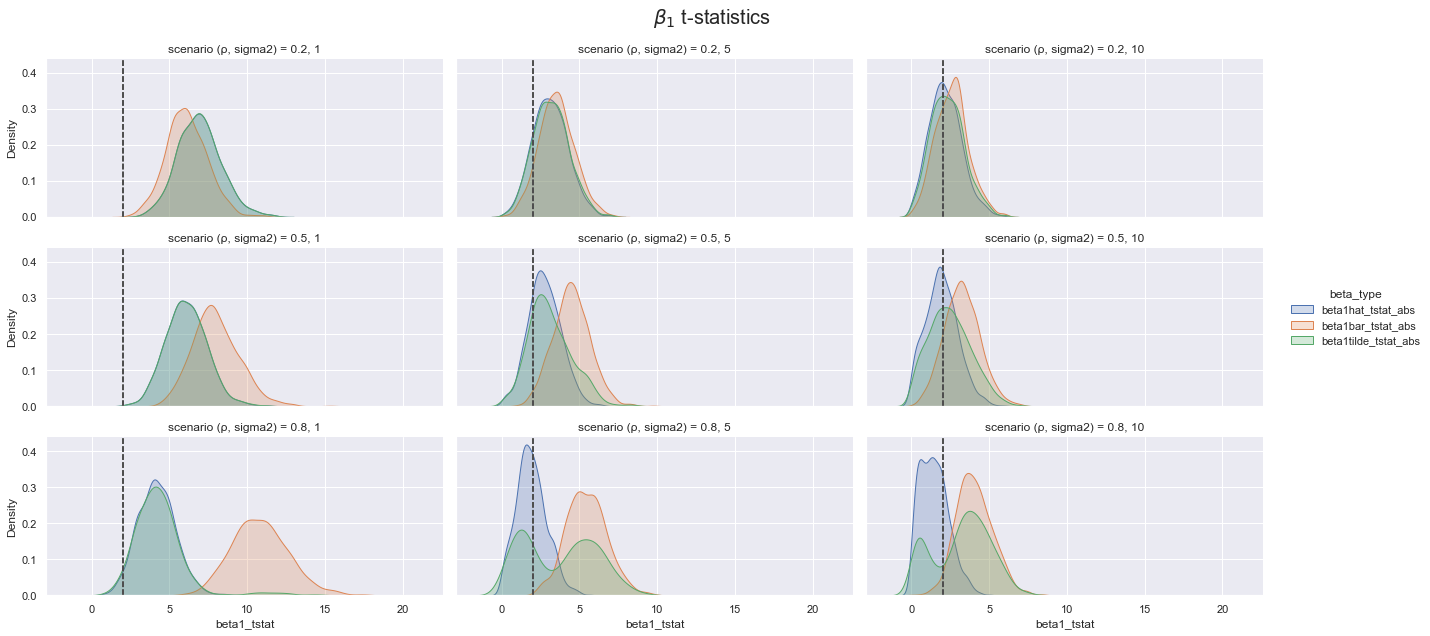

In [11]:
# Transform all t-stats into absolute values
all_scenarios["beta1hat_tstat_abs"] = np.abs(all_scenarios["beta1hat_tstat"])
all_scenarios["beta1bar_tstat_abs"] = np.abs(all_scenarios["beta1bar_tstat"])
all_scenarios["beta1tilde_tstat_abs"] = np.abs(all_scenarios["beta1tilde_tstat"])
# Manipulate a subset of the dataset (t-stat data) for better plotting
subset_tvals = all_scenarios[["scenario (ρ, sigma2)", 
                              "beta1hat_tstat_abs", 
                              "beta1bar_tstat_abs", 
                              "beta1tilde_tstat_abs"]]
subset_tvals = pd.melt(subset_tvals, id_vars="scenario (ρ, sigma2)", var_name="beta_type", value_name="beta1_tstat")

g = sns.FacetGrid(subset_tvals,
                  col="scenario (ρ, sigma2)",
                  col_wrap=3,
                  aspect=2,
                  hue="beta_type")

g.map(sns.kdeplot, "beta1_tstat", **{"fill": True, "warn_singular": True})
g.add_legend()
g.refline(x=2, color="0.3") # Significance cutoff of 2
g.fig.subplots_adjust(top=0.9) # adjust the figure
g.fig.suptitle("$β_1$ t-statistics", fontsize=20)
g.savefig("tstats")

In Figure 5, we can see that when covariance and variance are low, our t-statistic distributions for beta 1 in both procedure 1 and 3 are visually indistinguishable and significant. This result is no surprise, as the models for procedure 1 and 3 are going to be the same. Moving rightward, observe that as the variance increases, standard errors will increase with it, and consequently lead to lower t-statistic levels - or t-statistics closer to 2 - making beta 1 less significant. As covariance increases, we can see that (looking downwards) beta1_tstat for procedures 1 and 3 become visibly seperable because standard errors become bigger - effects between X_1 and X_2 become harder to differentiate - and beta 2s begin to get dropped in procedure 3 (the green). For procedure 2 we see that opposite effects, most clearly seen looking down the first column of graphs, where the higher multicollinearity leads to a more significant results, as beta1_bar will be able to capture the effects from beta 2 when its dropped – this can also be called a Type I error. 

Also observe the fact that the beta1_tstats become bimodal in our procedure 3 results. This formation suggests that as X_1 and X_2 become more linearly depenedent beta1_tilde – the variable that switches between beta1_hat and beta1_bar – will assume the characteristics of the estimators that they switch to. In other words, beta1_tilde in the case where beta2_hat remains significant tracks the behaviour of our blue distribution (of beta1_hat) because, when multicollinearity and variance is high it becomes harder to differentiate between the effects from X_1 and X_2, making it less significant or a movement of the t-statistic distribution towards the dotted line. In the opposite case, when beta1_tilde matches beta1_bar (the model without beta2_hat) we can see that its behaviour matches the orange distribution (beta1_bar) because, with high multicollinearity, the absence of X_2 allows X_1 (beta1_bar) to soak up much of the explanatory power from X_2. This effect allows beta1_tilde to be able to explain more of the variance and be more significant (when beta2_hat is dropped). 

### R-Squared

#### Last, discuss how the distribution of R2 varies across these three procedures as ρ and σ2 change. the finite sample performance across the above.

In [12]:
subset_r = all_scenarios[["scenario (ρ, sigma2)", "rsquared1", "rsquared2", "rsquared3"]]
subset_r = pd.melt(subset_r, id_vars="scenario (ρ, sigma2)", var_name="Procedure", value_name="R-squared")

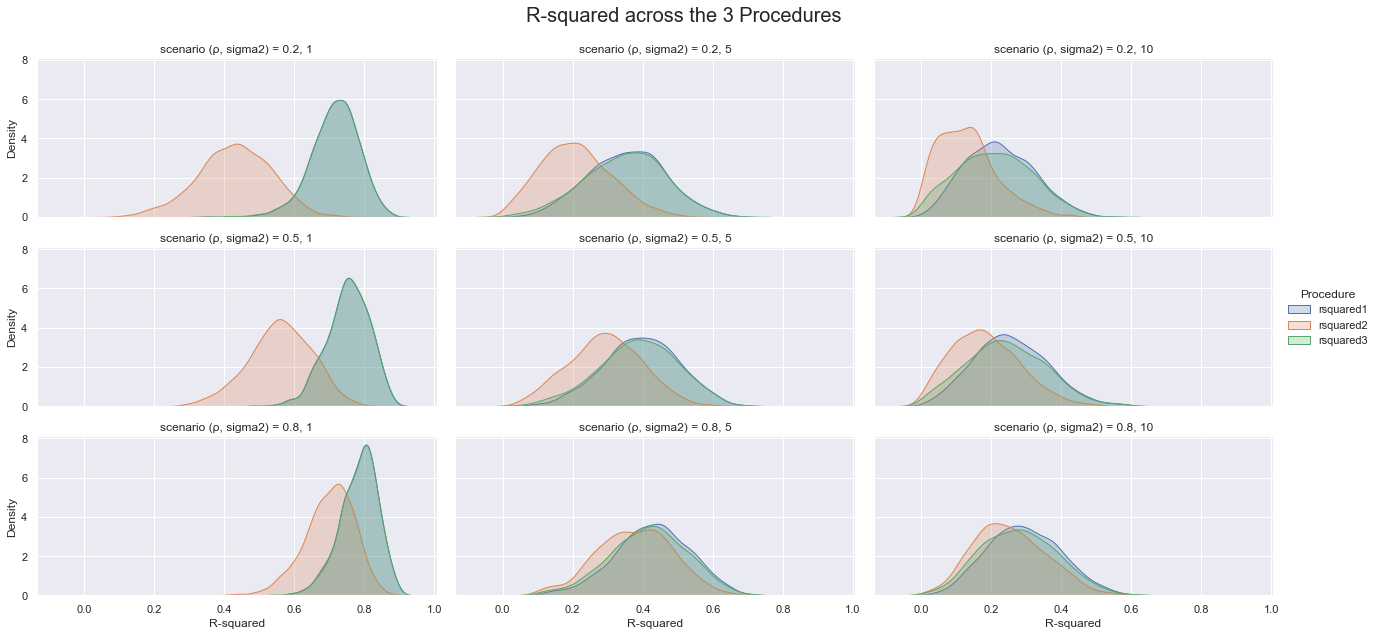

In [13]:
g = sns.FacetGrid(subset_r,
                  col="scenario (ρ, sigma2)", 
                  col_wrap=3, 
                  aspect=2,
                  hue="Procedure")

g.map(sns.kdeplot, "R-squared", **{"fill": True, "warn_singular": True})
g.add_legend()
g.fig.subplots_adjust(top=0.9) # adjust the figure
g.fig.suptitle("R-squared across the 3 Procedures", fontsize=20)
g.savefig("rsquared")

It is evident in Figure 6 that as we look down each of the three columns, when the covariance is increased, the R-squared values increase for procedure 2. 
The R-squared value for procedure 2 increases as the covariance increases since beta1_bar captures the effect of beta 2_hat, letting beta1_bar explain a greater proportion of the variance. The R-squared values for procedures and 1 and 3 increase only slightly, since the variance of the regression is already explained by x1 and x2, thus the increase in covariance doesn’t impact the R-squared by much for those procedures. As we increase error variance, we can see that it decreases R-squared for all three procedures. The R-squared is a function of the error variance, which can be seen in the following formula:

$R_n^2=1-  \frac{var(e_i )} {var(Y_i )}$


We can see that as we increase the variance of the error term, R-squared decreases. This is because we are increasing the percentage of the variation in our model that can’t be explained. 

### Some Tables

In [14]:
all_scenarios.describe().T

,count,mean,std,min,25%,50%,75%,max
beta1_hat,9000.0,1.003611,0.445554,-1.7711,0.779175,0.99770,1.221850,4.1221
beta2_hat,9000.0,1.005244,0.449151,-1.7228,0.783250,1.00735,1.226425,3.4891
beta1_bar,9000.0,1.507632,0.433399,-0.3738,1.223675,1.51105,1.790175,3.2920
beta2_tstat,9000.0,3.378578,2.201251,-2.0391,1.779700,2.89440,4.749575,13.5974
beta1hat_tstat,9000.0,3.368978,2.184997,-1.9004,1.766275,2.88185,4.739250,11.9390
beta1bar_tstat,9000.0,5.356559,2.812464,-0.8516,3.309000,4.73580,6.812825,20.0519
rsquared1,9000.0,0.466359,0.229276,0.0061,0.278300,0.41580,0.708600,0.9129
rsquared2,9000.0,0.348129,0.201111,0.0000,0.185775,0.31845,0.491600,0.8934
beta1_tilde,9000.0,1.115427,0.517314,-1.7711,0.829575,1.05510,1.374650,3.2920
beta1tilde_tstat,9000.0,3.907900,2.201377,-1.9004,2.293350,3.69365,5.410875,17.2205


In [15]:
all_scenarios.groupby(["scenario (ρ, sigma2)"]).mean().T

"scenario (ρ, sigma2)","0.2, 1","0.2, 10","0.2, 5","0.5, 1","0.5, 10","0.5, 5","0.8, 1","0.8, 10","0.8, 5"
beta1_hat,1.001704,0.992076,1.006408,0.997078,0.993395,1.021688,0.996298,1.007957,1.015897
beta2_hat,1.003668,1.013896,1.029705,1.002931,1.004992,0.995905,1.006614,1.016314,0.973167
beta1_bar,1.205478,1.204404,1.216582,1.491353,1.501665,1.525033,1.800522,1.825356,1.798299
beta2_tstat,6.945536,2.218112,3.174726,6.076509,1.920730,2.697665,4.207434,1.342071,1.824417
beta1hat_tstat,6.910340,2.162606,3.114095,6.075519,1.905691,2.748953,4.171435,1.344660,1.887500
beta1bar_tstat,6.096883,2.583130,3.527836,7.972378,3.232588,4.480414,10.831281,4.033235,5.451286
rsquared1,0.714597,0.223706,0.353574,0.751540,0.256057,0.394385,0.782783,0.294335,0.426252
rsquared2,0.428300,0.131125,0.209334,0.559086,0.184162,0.292878,0.698949,0.253228,0.376098
beta1_tilde,1.001806,1.045422,1.022049,0.997328,1.148687,1.094436,1.007026,1.419070,1.303016
beta1tilde_tstat,6.911077,2.300839,3.168351,6.079624,2.437931,3.115287,4.365161,3.111749,3.681081
